# Analisis Sentimen Terhadap Ulasan Aplikasi ChatGPT

## 1. Import Library

In [ ]:
# Instalasi library Sastrawi
# Sastrawi adalah library Python untuk stemming Bahasa Indonesia
!pip install Sastrawi

# Instalasi library Gensim
# Gensim adalah library Python populer untuk pemrosesan teks
!pip install gensim

In [ ]:
# Mengimport library yang diperlukan
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gensim.downloader as api
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import joblib

## 2. Load Dataset

In [ ]:
# Contoh load dataset CSV hasil scraping
df_ulasan = pd.read_csv('/content/chatgpt_reviews.csv')

In [ ]:
# Jumlah ulasan pada dataframe
len(df_ulasan.index)

20000

In [ ]:
df_ulasan.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,ed55cbd1-7a5c-42c1-a672-467091973fa8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aku sudah pakai aplikasi ChatGPT ini beberapa ...,5,36,1.2025.231,2025-09-11 14:05:38,NaN,NaN,1.2025.231
1,2e221a22-0619-4f59-ba37-9aeaca684930,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"""Aplikasi ini sebenarnya bagus, tapi sayangnya...",1,37,1.2025.245,2025-09-10 17:04:53,NaN,NaN,1.2025.245
2,fa5c3580-8687-455f-9d60-94875b4cadd7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kadang gpt buat kalimat sulit yang sulit dimen...,2,4,1.2025.245,2025-09-10 20:11:48,NaN,NaN,1.2025.245
3,a5f555e7-3400-4fdd-b841-add010e90446,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi yang sangat berguna untuk menunjang p...,5,706,1.2025.231,2025-09-01 06:02:19,NaN,NaN,1.2025.231
4,53e60a5d-6bea-45b6-b9ac-ba1e3009989d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sudah bagus sih aplikasinya, sayangnya untuk p...",5,458,1.2025.231,2025-09-06 03:43:10,NaN,NaN,1.2025.231


## 3. Text Preprocessing

In [ ]:
# Memilih kolom-kolom yang diperlukan
new_df = df_ulasan[['content', 'score']].copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
# Menghapus data yang duplikat
new_df.drop_duplicates(subset = 'content', keep = 'first', inplace = True)

In [ ]:
# Hasil setelah data duplikat sudah dihapus
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19636 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  19636 non-null  object
 1   score    19636 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 460.2+ KB


In [ ]:
# Membuat salinan (copy) penuh dari DataFrame new_df agar aman digunakan
# Copy ini mencegah munculnya SettingWithCopyWarning ketika kita melakukan perubahan
clean_df = new_df.copy()
clean_df.head()

,content,score
0,Aku sudah pakai aplikasi ChatGPT ini beberapa ...,5
1,"""Aplikasi ini sebenarnya bagus, tapi sayangnya...",1
2,Kadang gpt buat kalimat sulit yang sulit dimen...,2
3,Aplikasi yang sangat berguna untuk menunjang p...,5
4,"sudah bagus sih aplikasinya, sayangnya untuk p...",5


### 3.1 Remove Special Characters

In [ ]:
# Fungsi untuk menghapus karakter spesial dari sebuah teks
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

clean_df['remove_special_characters'] = clean_df['content'].apply(remove_special_characters)

### 3.2 Case Folding

In [ ]:
# Fungsi untuk mengubah teks menjadi huruf kecil
def case_folding(text):
    return text.lower()

clean_df['case_folding'] = clean_df['remove_special_characters'].apply(case_folding)

### 3.3 Normalization

In [ ]:
# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
    # Jika teks bertipe string
    if isinstance(text, str):
        # Memisahkan teks menjadi kata-kata
        words = text.split()
        # List untuk menyimpan kata-kata yang sudah diganti
        replaced_words = []
        # List untuk menyimpan kalimat baku
        kalimat_baku = []
        # List untuk menyimpan kata yang diganti
        kata_diganti = []
        # List untuk menyimpan hash kata tidak baku
        kata_tidak_baku_hash = []

        # Iterasi melalui setiap kata dalam teks
        for word in words:
            # Jika kata ditemukan dalam kamus kata tidak baku
            if word in kamus_tidak_baku:
                # Ambil kata baku dari kamus
                baku_word = kamus_tidak_baku[word]
                # Jika kata baku bertipe string dan hanya berisi huruf
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    # Tambahkan kata baku ke list replaced_words
                    replaced_words.append(baku_word)
                    # Tambahkan kata baku ke list kalimat_baku
                    kalimat_baku.append(baku_word)
                    # Tambahkan kata tidak baku ke list kata_diganti
                    kata_diganti.append(word)
                    # Tambahkan hash kata tidak baku ke list kata_tidak_baku_hash
                    kata_tidak_baku_hash.append(hash(word))
            # Jika kata tidak ditemukan dalam kamus kata tidak baku
            else:
                # Tambahkan kata apa adanya ke list replaced_words
                replaced_words.append(word)
        # Gabungkan kata-kata yang sudah diganti menjadi teks utuh
        replaced_text = ' '.join(replaced_words)
    # Jika teks bukan string
    else:
        # Set replaced_text menjadi string kosong
        replaced_text = ''
        # Inisialisasi list kalimat_baku, kata_diganti, dan kata_tidak_baku_hash
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    # Kembalikan teks yang sudah diganti, kalimat baku, kata yang diganti, dan hash kata tidak baku
    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

In [ ]:
# Baca dataset
data =  pd.DataFrame(clean_df[['content', 'score', 'remove_special_characters', 'case_folding']])

# Baca kamus kata tidak baku
kamus_data = pd.read_csv('/content/kamuskatabaku.csv')
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

In [ ]:
# Terapkan fungsi penggantian kata tidak baku
data['normalization'], data['Kata_Baku'], data['Kata_Tidak_Baku'], data['Kata_Tidak_Baku_Hash'] = zip(*data['case_folding'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku)))

clean_df =  pd.DataFrame(data[['content', 'score', 'remove_special_characters', 'case_folding', 'normalization']])

### 3.4 Tokenization

In [ ]:
# Mendownload resources 'punkt_tab' yang dipakai untuk melakukan Tokenization
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Fungsi untuk memisahkan teks menjadi unit-unit terkecil
def tokenization(text):
    return word_tokenize(text)

clean_df['tokenization'] = clean_df['normalization'].apply(tokenization)

### 3.5 Stopwords Removal

In [ ]:
# Mendownload resources stopwords yang dipakai untuk melakukan Stopwords Removal
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Fungsi untuk menghapus kata-kata umum yang memiliki informasi yang tidak penting
stop_words = set(stopwords.words('indonesian'))

def stopwords_removal(text):
    return [word for word in text if word not in stop_words]

clean_df['stopwords_removal'] = clean_df['tokenization'].apply(stopwords_removal)

### 3.6 Stemming

In [ ]:
# Import StemmerFactory dari library Sastrawi untuk stemming bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk melakukan stemming (mengubah kata ke bentuk dasar) pada list kata
def stemming(text_list):
    return [stemmer.stem(word) for word in text_list]

clean_df['stemming'] = clean_df['stopwords_removal'].apply(lambda x: ' '.join(stemming(x)))

In [ ]:
# Menampilkan dataset setelah Text Preprocessing
clean_df.head()

,content,score,remove_special_characters,case_folding,normalization,tokenization,stopwords_removal,stemming
0,Aku sudah pakai aplikasi ChatGPT ini beberapa ...,5,Aku sudah pakai aplikasi ChatGPT ini beberapa ...,aku sudah pakai aplikasi chatgpt ini beberapa ...,aku sudah pakai aplikasi chatgpt ini beberapa ...,"[aku, sudah, pakai, aplikasi, chatgpt, ini, be...","[pakai, aplikasi, chatgpt, menurutku, aplikasi...",pakai aplikasi chatgpt turut aplikasi bantu se...
1,"""Aplikasi ini sebenarnya bagus, tapi sayangnya...",1,Aplikasi ini sebenarnya bagus tapi sayangnya b...,aplikasi ini sebenarnya bagus tapi sayangnya b...,aplikasi ini sebenarnya bagus tapi sayangnya b...,"[aplikasi, ini, sebenarnya, bagus, tapi, sayan...","[aplikasi, bagus, sayangnya, bikin, pengguna, ...",aplikasi bagus sayang bikin guna kecewa jelas ...
2,Kadang gpt buat kalimat sulit yang sulit dimen...,2,Kadang gpt buat kalimat sulit yang sulit dimen...,kadang gpt buat kalimat sulit yang sulit dimen...,kadang gpt buat kalimat sulit yang sulit dimen...,"[kadang, gpt, buat, kalimat, sulit, yang, suli...","[kadang, gpt, kalimat, sulit, sulit, dimengert...",kadang gpt kalimat sulit sulit erti hafalin aj...
3,Aplikasi yang sangat berguna untuk menunjang p...,5,Aplikasi yang sangat berguna untuk menunjang p...,aplikasi yang sangat berguna untuk menunjang p...,aplikasi yang sangat berguna untuk menunjang p...,"[aplikasi, yang, sangat, berguna, untuk, menun...","[aplikasi, berguna, menunjang, produktifitas, ...",aplikasi guna tunjang produktifitas cari mater...
4,"sudah bagus sih aplikasinya, sayangnya untuk p...",5,sudah bagus sih aplikasinya sayangnya untuk pe...,sudah bagus sih aplikasinya sayangnya untuk pe...,sudah bagus sih aplikasinya sayangnya untuk pe...,"[sudah, bagus, sih, aplikasinya, sayangnya, un...","[bagus, sih, aplikasinya, sayangnya, pengguna,...",bagus sih aplikasi sayang guna free credit min...


## 4. Data Labeling

In [ ]:
# Memilih kolom 'stemming' untuk digunakan dalam pemodelan
preprocessed_df = clean_df[['stemming']].copy()
preprocessed_df.head()

,stemming
0,pakai aplikasi chatgpt turut aplikasi bantu se...
1,aplikasi bagus sayang bikin guna kecewa jelas ...
2,kadang gpt kalimat sulit sulit erti hafalin aj...
3,aplikasi guna tunjang produktifitas cari mater...
4,bagus sih aplikasi sayang guna free credit min...


In [ ]:
# Fungsi untuk menghitung polarity dan mengubah ke kelas sentimen
def get_textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Terapkan fungsi untuk mendapatkan kelas sentimen pada kolom 'stemming'
preprocessed_df['sentiment'] = preprocessed_df['stemming'].apply(get_textblob_sentiment)

In [ ]:
# Menampilkan jumlah sentimen positif, negatif, dan netral
sentiment_counts = preprocessed_df['sentiment'].value_counts()

print("\nJumlah Sentimen Positif, Negatif, Netral:")
print(sentiment_counts)


Jumlah Sentimen Positif, Negatif, Netral:
sentiment
neutral     17972
positive     1247
negative      417
Name: count, dtype: int64


## 5. Data Visualization

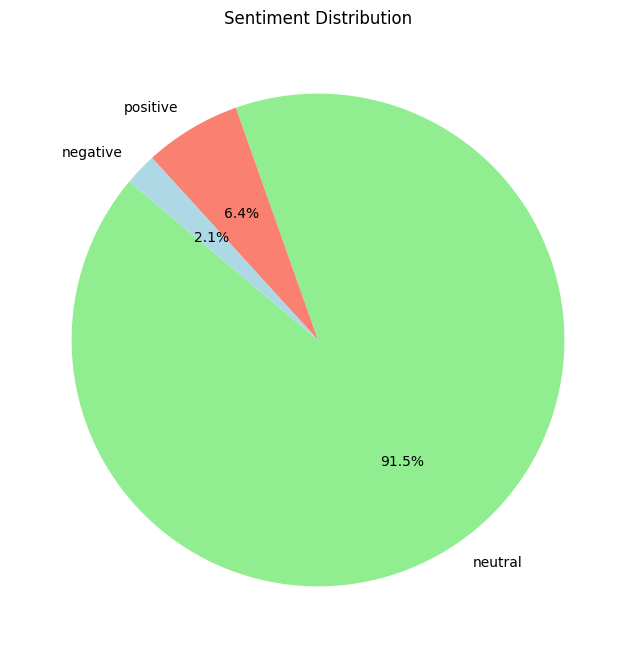

In [ ]:
# Menampilkan diagram pie chart untuk memudahkan visualisasi
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'salmon', 'lightblue'])
plt.title('Sentiment Distribution')
plt.show()

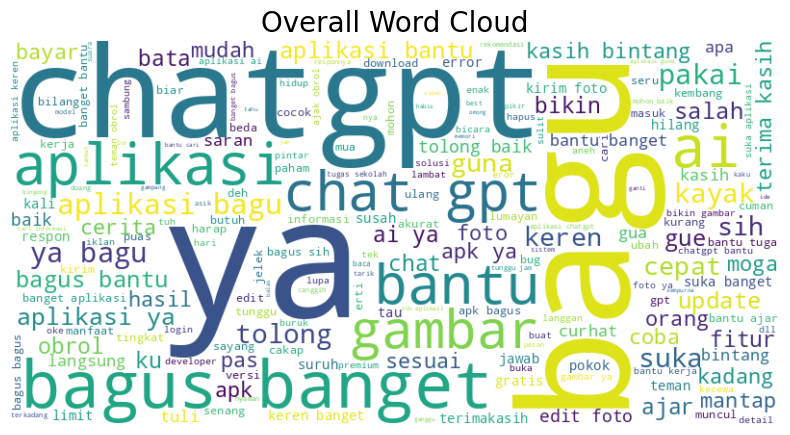

In [ ]:
# Gabungkan semua kalimat/judul/teks menjadi satu string
all_text = " ".join(preprocessed_df['stemming'])

# Buat word cloud
wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Tampilkan
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Overall Word Cloud", fontsize=20)
plt.show()

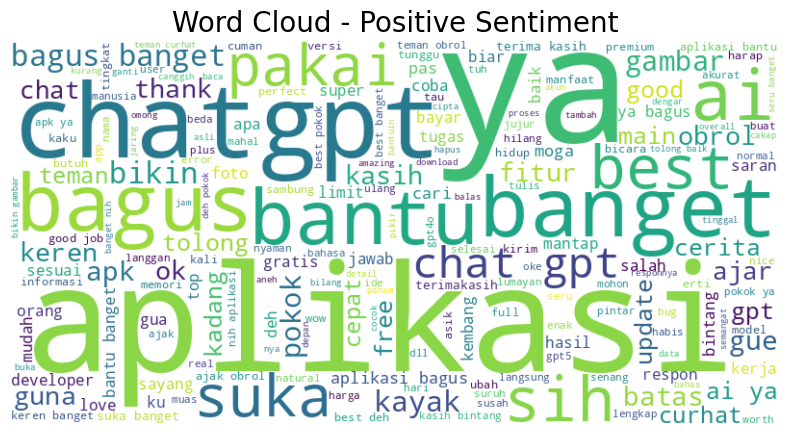

In [ ]:
# Filter untuk ulasan dengan sentimen positif
positive_reviews = preprocessed_df[preprocessed_df['sentiment'] == 'positive']

# Gabungkan list token menjadi string per review, lalu gabungkan semua review
positive_words = " ".join(
    [" ".join(tokens) if isinstance(tokens, list) else str(tokens)
     for tokens in positive_reviews['stemming']]
)

# Hasilkan word cloud positif
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Tampilkan word cloud positif
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiment', fontsize=20)
plt.show()

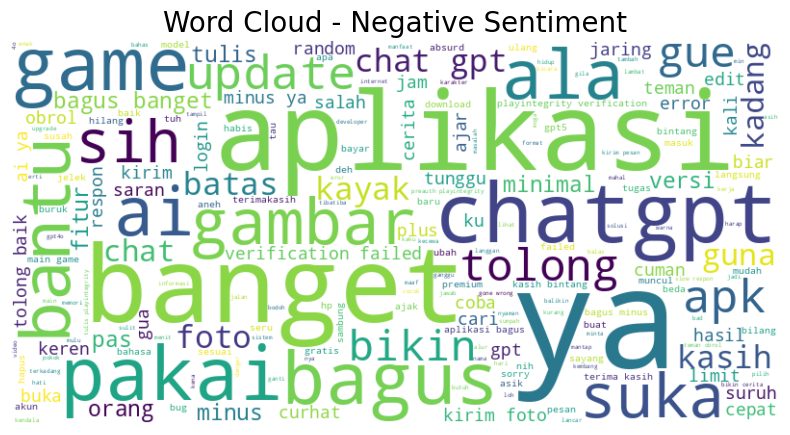

In [ ]:
# Filter untuk ulasan dengan sentimen negatif
negative_reviews = preprocessed_df[preprocessed_df['sentiment'] == 'negative']

# Gabungkan list token menjadi string per review, lalu satukan semua review
negative_words = " ".join(
    [" ".join(tokens) if isinstance(tokens, list) else str(tokens)
     for tokens in negative_reviews['stemming']]
)

# Hasilkan word cloud negatif
negative_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_words)

# Menampilkan word cloud negatif
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment", fontsize=20)
plt.show()

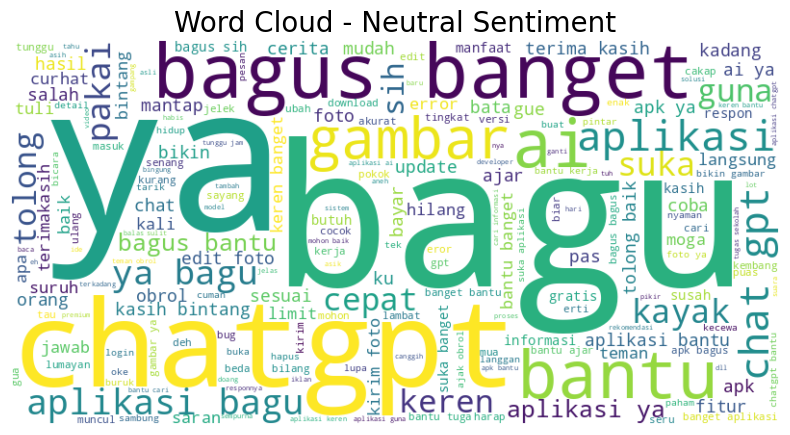

In [ ]:
# Filter untuk ulasan dengan sentimen netral
neutral_reviews = preprocessed_df[preprocessed_df['sentiment'] == 'neutral']

# Gabungkan list token menjadi string per review, lalu satukan semua review
neutral_words = " ".join(
    [" ".join(tokens) if isinstance(tokens, list) else str(tokens)
     for tokens in neutral_reviews['stemming']]
)

# Hasilkan word cloud netral
neutral_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(neutral_words)

# Menampilkan word cloud netral
plt.figure(figsize=(10, 5))
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment", fontsize=20)
plt.show()

## 6. Modeling

In [ ]:
# Encode label
X = preprocessed_df['stemming']
y = LabelEncoder().fit_transform(preprocessed_df['sentiment'])

### Skema 1: SVM + TF-IDF (80/20 split)

In [ ]:
# Pisahkan data menjadi train dan test
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# TF-IDF Vectorization
# Inisialisasi objek TfidfVectorizer untuk mengubah teks menjadi vektor numerik
vectorizer = TfidfVectorizer()
# Melatih vectorizer dan mengubah data latih menjadi vektor TF-IDF
X_train_vec = vectorizer.fit_transform(X_train_raw)
# Mengubah data uji menggunakan vectorizer yang sudah dilatih
X_test_vec = vectorizer.transform(X_test_raw)

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train_raw)

print("Shape of X_train before SMOTE:", X_train_vec.shape)
print("Shape of X_train after SMOTE:", X_train_resampled.shape)
print("Shape of y_train before SMOTE:", y_train_raw.shape)
print("Shape of y_train after SMOTE:", y_train_resampled.shape)

Shape of X_train before SMOTE: (15708, 11279)
Shape of X_train after SMOTE: (43131, 11279)
Shape of y_train before SMOTE: (15708,)
Shape of y_train after SMOTE: (43131,)


In [ ]:
# Inisialisasi model SVM
svm_model = SVC(kernel="linear", probability=True, random_state=42)

# Latih model dengan data hasil SMOTE
svm_model.fit(X_train_resampled, y_train_resampled)

# Prediksi pada data training
y_train_pred_svm = svm_model.predict(X_train_resampled)

# Prediksi pada data testing
y_test_pred_svm = svm_model.predict(X_test_vec)

# Evaluasi ukuran dataset
print(f"Jumlah X train (SMOTE): {X_train_resampled.shape[0]}")
print(f"Jumlah X test: {X_test_raw.shape[0]}")
print(f"Jumlah y train (SMOTE): {len(y_train_resampled)}")
print(f"Jumlah y test: {len(y_test_raw)}")

# Akurasi training dan testing
train_acc = accuracy_score(y_train_resampled, y_train_pred_svm)
test_acc = accuracy_score(y_test_raw, y_test_pred_svm)

print(f"\nAkurasi Training: {train_acc * 100:.2f}%")
print(f"Akurasi Testing : {test_acc * 100:.2f}%")

# Hitung jumlah benar/salah (testing)
correct = np.sum(y_test_raw == y_test_pred_svm)
wrong = len(y_test_raw) - correct
print(f"\nJumlah prediksi benar (Testing): {correct}")
print(f"Jumlah prediksi salah (Testing): {wrong}")

# Classification Report (Testing)
print("\nClassification Report (Testing Data):\n",
      classification_report(y_test_raw, y_test_pred_svm, target_names=["negative", "neutral", "positive"]))

# Confusion Matrix (Testing)
print("\nConfusion Matrix (Testing Data):\n",
      confusion_matrix(y_test_raw, y_test_pred_svm))

Jumlah X train (SMOTE): 43131
Jumlah X test: 3928
Jumlah y train (SMOTE): 43131
Jumlah y test: 3928

Akurasi Training: 99.99%
Akurasi Testing : 98.68%

Jumlah prediksi benar (Testing): 3876
Jumlah prediksi salah (Testing): 52

Classification Report (Testing Data):
               precision    recall  f1-score   support

    negative       0.97      0.73      0.84        83
     neutral       0.99      1.00      0.99      3595
    positive       0.97      0.90      0.93       250

    accuracy                           0.99      3928
   macro avg       0.97      0.88      0.92      3928
weighted avg       0.99      0.99      0.99      3928


Confusion Matrix (Testing Data):
 [[  61   18    4]
 [   1 3590    4]
 [   1   24  225]]


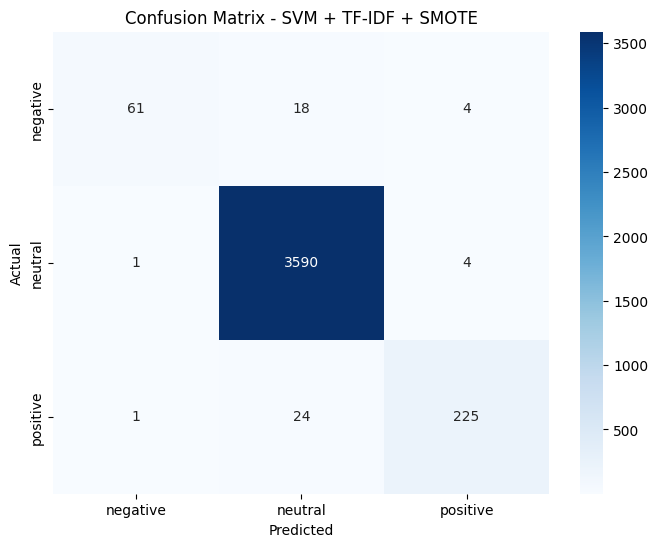

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_raw, y_test_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM + TF-IDF + SMOTE')
plt.show()

In [65]:
# Save the trained SVM model
joblib.dump(svm_model, 'svm_model.pkl')
print("Trained SVM model saved as 'svm_model.pkl'")

Trained SVM model saved as 'svm_model.pkl'


### Skema 2: Random Forest + Word2Vec (70/30 split)

In [ ]:
# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Load Word2Vec
print("Loading Word2Vec model... (butuh waktu)")
w2v_model = api.load("word2vec-google-news-300")

# Fungsi ubah teks -> vektor rata-rata Word2Vec
def document_vector(doc):
    words = [word for word in doc.split() if word in w2v_model.key_to_index]
    if len(words) == 0:
        return np.zeros(300)
    return np.mean(w2v_model[words], axis=0)

# Konversi teks menjadi Word2Vec
X_w2v = np.array([document_vector(" ".join(tokens)) for tokens in X])

Loading Word2Vec model... (butuh waktu)
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Split data (70/30)
X_train_raw2, X_test_raw2, y_train_raw2, y_test_raw2 = train_test_split(
    X_w2v, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print("Sebelum SMOTE:", np.bincount(y_train_raw2))

# Terapkan SMOTE hanya pada data training
smote = SMOTE(random_state=42)
X_train_resampled2, y_train_resampled2 = smote.fit_resample(X_train_raw2, y_train_raw2)

print("Setelah SMOTE:", np.bincount(y_train_resampled2))

Sebelum SMOTE: [  292 12580   873]
Setelah SMOTE: [12580 12580 12580]


In [67]:
# Latih model Random Forest
rf_model = RandomForestClassifier(
    n_estimators=250,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Latih model
rf_model.fit(X_train_resampled2, y_train_resampled2)

# Prediksi training
y_train_pred_rf = rf_model.predict(X_train_resampled2)

# Prediksi testing
y_test_pred_rf = rf_model.predict(X_test_raw2)

# Evaluasi ukuran dataset
print(f"Jumlah X train (SMOTE): {X_train_resampled2.shape[0]}")
print(f"Jumlah X test: {X_test_raw2.shape[0]}")
print(f"Jumlah y train (SMOTE): {len(y_train_resampled2)}")
print(f"Jumlah y test: {len(y_test_raw2)}")

# Akurasi training dan testing
train_acc = accuracy_score(y_train_resampled2, y_train_pred_rf)
test_acc = accuracy_score(y_test_raw2, y_test_pred_rf)

print(f"\nAkurasi Training: {train_acc * 100:.2f}%")
print(f"Akurasi Testing : {test_acc * 100:.2f}%")

# Hitung jumlah benar/salah (testing)
correct = np.sum(y_test_raw2 == y_test_pred_rf)
wrong = len(y_test_raw2) - correct
print(f"\nJumlah prediksi benar (Testing): {correct}")
print(f"Jumlah prediksi salah (Testing): {wrong}")

# Classification Report (Testing)
print("\nClassification Report (Testing Data):\n",
      classification_report(y_test_raw2, y_test_pred_rf, target_names=["negative", "neutral", "positive"]))

# Confusion Matrix (Testing)
print("\nConfusion Matrix (Testing Data):\n",
      confusion_matrix(y_test_raw2, y_test_pred_rf))

Jumlah X train (SMOTE): 37740
Jumlah X test: 5891
Jumlah y train (SMOTE): 37740
Jumlah y test: 5891

Akurasi Training: 99.53%
Akurasi Testing : 85.76%

Jumlah prediksi benar (Testing): 5052
Jumlah prediksi salah (Testing): 839

Classification Report (Testing Data):
               precision    recall  f1-score   support

    negative       0.09      0.12      0.11       125
     neutral       0.94      0.92      0.93      5392
    positive       0.22      0.27      0.25       374

    accuracy                           0.86      5891
   macro avg       0.42      0.44      0.43      5891
weighted avg       0.87      0.86      0.86      5891


Confusion Matrix (Testing Data):
 [[  15   90   20]
 [ 125 4935  332]
 [  20  252  102]]


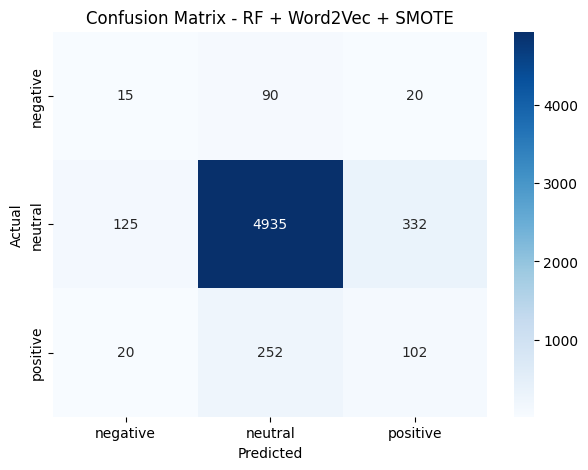

In [68]:
# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test_raw2, y_test_pred_rf)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF + Word2Vec + SMOTE")
plt.show()

In [70]:
# Simpan model dan label encoder
joblib.dump(rf_model, "random_forest_sentiment_model.pkl")
print("Trained SVM model saved as 'random_forest_sentiment_model.pkl'")

Trained SVM model saved as 'random_forest_sentiment_model.pkl'


### Skema 3: Deep Learning LSTM (70/30 split)

In [ ]:
# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(preprocessed_df['sentiment'])
y_categorical = to_categorical(y_encoded)  # one-hot untuk multiclass

# Split data (70/30)
X_train_raw3, X_test_raw3, y_train_raw3, y_test_raw3 = train_test_split(
    clean_df['stemming'], y_categorical, test_size=0.3, random_state=42, stratify=y_encoded
)

In [ ]:
# Tokenizer + Padding
max_words = 10000   # jumlah vocab
max_len = 100       # panjang sequence maksimum

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw3)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw3)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw3)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Bangun model LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compile model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definisikan early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # metrik yang dipantau
    patience=3,           # berhenti kalau 3 epoch berturut-turut tidak membaik
    restore_best_weights=True # kembalikan bobot terbaik
)

# Latih model
history = lstm_model.fit(
    X_train_pad, y_train_raw3,
    validation_data=(X_test_pad, y_test_raw3),
    epochs=15,
    batch_size=64,
    verbose=1
)

Epoch 1/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 92s 400ms/step - accuracy: 0.8907 - loss: 0.4564 - val_accuracy: 0.9153 - val_loss: 0.3381
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 89s 413ms/step - accuracy: 0.9155 - loss: 0.3582 - val_accuracy: 0.9153 - val_loss: 0.3402
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 141s 409ms/step - accuracy: 0.9142 - loss: 0.3615 - val_accuracy: 0.9153 - val_loss: 0.3390
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 141s 404ms/step - accuracy: 0.9142 - loss: 0.3643 - val_accuracy: 0.9153 - val_loss: 0.3405
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 135s 372ms/step - accuracy: 0.9153 - loss: 0.3526 - val_accuracy: 0.9153 - val_loss: 0.3405
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 85s 386ms/step - accuracy: 0.9161 - loss: 0.3525 - val_accuracy: 0.9153 - val_loss: 0.3418
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 143s 392ms/step - accuracy: 0.9139 - loss: 0.3573 - val_accuracy: 0.9153 - val_loss: 0.3410
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 85s 396ms/step - accuracy: 0.9111 - los

In [74]:
# Evaluasi
loss, acc = lstm_model.evaluate(X_test_pad, y_test_raw3, verbose=0)

# Ambil akurasi training & testing dari epoch terakhir
train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]

print("\n=== Evaluasi LSTM ===")
print(f"Akurasi Training (epoch terakhir): {train_acc*100:.2f}%")
print(f"Akurasi Testing  (epoch terakhir): {val_acc*100:.2f}%")
print(f"Akurasi Evaluasi langsung (evaluate): {test_acc*100:.2f}%")


=== Evaluasi LSTM ===
Akurasi Training (epoch terakhir): 91.52%
Akurasi Testing  (epoch terakhir): 91.53%
Akurasi Evaluasi langsung (evaluate): 9867.62%


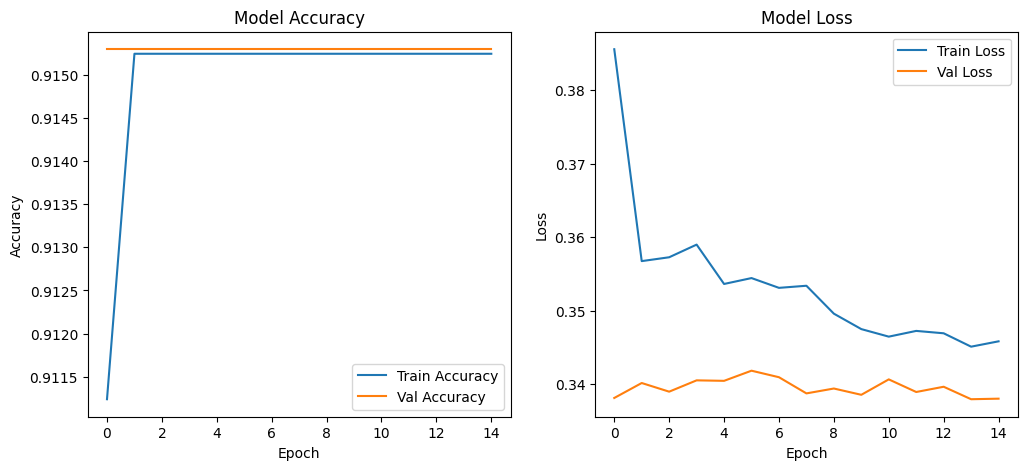

In [75]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [76]:
# Simpan model (gunakan format .keras terbaru)
lstm_model.save("lstm_sentiment_model.keras")
print("Trained LSTM model saved as 'lstm_sentiment_model.keras'")

Trained LSTM model saved as 'lstm_sentiment_model.keras'


## Testing

In [71]:
# Bandingkan akurasi ketiga model

# SVM
train_acc_svm = accuracy_score(y_train_resampled, y_train_pred_svm) * 100
test_acc_svm  = accuracy_score(y_test_raw, y_test_pred_svm) * 100

# Random Forest
train_acc_rf = accuracy_score(y_train_resampled2, y_train_pred_rf) * 100
test_acc_rf  = accuracy_score(y_test_raw2, y_test_pred_rf) * 100

# LSTM
train_acc_lstm = history.history['accuracy'][-1] * 100       # epoch terakhir (training)
test_acc_lstm  = history.history['val_accuracy'][-1] * 100   # epoch terakhir (validation/testing)

print("=== Perbandingan Akurasi Training vs Testing ===")
print(f"- SVM + TF-IDF        -> Training: {train_acc_svm:.2f}% | Testing: {test_acc_svm:.2f}%")
print(f"- Random Forest + W2V -> Training: {train_acc_rf:.2f}% | Testing: {test_acc_rf:.2f}%")
print(f"- LSTM                -> Training: {train_acc_lstm:.2f}% | Testing: {test_acc_lstm:.2f}%")

=== Perbandingan Akurasi Training vs Testing ===
- SVM + TF-IDF        -> Training: 99.99% | Testing: 98.68%
- Random Forest + W2V -> Training: 99.53% | Testing: 85.76%
- LSTM                -> Training: 91.52% | Testing: 91.53%


In [72]:
# === Gunakan label encoder yang sama ===
def decode_labels(y_encoded):
    return label_encoder.inverse_transform(y_encoded)

# === Pilih model terbaik berdasarkan akurasi testing ===
best_model_name = max(
    [("SVM", test_acc_svm), ("Random Forest", test_acc_rf), ("LSTM", test_acc_lstm)],
    key=lambda x: x[1]
)[0]

print(f"\nModel terbaik berdasarkan akurasi Testing: {best_model_name}")


Model terbaik berdasarkan akurasi Testing: SVM


In [73]:
print("\n=== Evaluasi Model Terbaik ===")

if best_model_name == 'SVM':
    train_acc = accuracy_score(y_train_resampled, y_train_pred_svm) * 100
    test_acc  = accuracy_score(y_test_raw, y_test_pred_svm) * 100

elif best_model_name == 'Random Forest':
    train_acc = accuracy_score(y_train_resampled2, y_train_pred_rf) * 100
    test_acc  = accuracy_score(y_test_raw2, y_test_pred_rf) * 100

else:  # LSTM
    train_acc = history.history['accuracy'][-1] * 100
    test_acc  = history.history['val_accuracy'][-1] * 100

print(f"Model Terbaik: {best_model_name}")
print(f"Akurasi Training : {train_acc:.2f}%")
print(f"Akurasi Testing  : {test_acc:.2f}%")


=== Evaluasi Model Terbaik ===
Model Terbaik: SVM
Akurasi Training : 99.99%
Akurasi Testing  : 98.68%


In [ ]:
!pip freeze requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.15
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.16.5
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.10.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy==7.1.0
astropy-iers-data==0.2025.9.8.0.36.17
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
Authlib==1.6.3
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.21.0
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.19.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.7.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.8.3
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.3
chex==0.1.90
clara